# Check-worthiness detection using Large Language Models

First, the necessary python modules are imported

In [3]:
%load_ext autoreload

from claimbuster_utils import load_claimbuster_dataset
from checkthat_utils import load_check_that_dataset
import pandas as pd
from llm import load_huggingface_model, HuggingFaceModel, run_llm_cross_validation, generate_llm_predictions, ICLUsage, PromptType
from result_analysis import generate_error_analysis_report, print_padded_text
from dataset_utils import generate_cross_validation_datasets, CustomDataset
import ipywidgets as widgets
import os
from huggingface_hub import login
import pandas as pd

## Login to HuggingFace hub

In order to get access to the LLama2 model, you need to login to the Huggingace hub and have gated access to the model. Otherwise this can be skipped

In [7]:
login()

## Generate Cross Validation datasets

In [2]:
%autoreload
claimbuster = load_claimbuster_dataset("../data/ClaimBuster/datasets")
clambuster_datasets = generate_cross_validation_datasets(
    data=claimbuster, 
    folder_path="../data/ClaimBuster/crossval"
)

checkthat = load_check_that_dataset("../data/CheckThat")
checkthat_datasets = generate_cross_validation_datasets(
    data=checkthat, 
    label_column="check_worthiness",
    folder_path="../data/CheckThat/crossval"
)

## Generate predictions

Using ipywidgets to select which model, dataset, and other parameters to generate LLM predictions

In [2]:
%autoreload

# General lauyout
input_style = dict(
    description_width="fit-content"
)

# Dataset 
dataset_select = widgets.Dropdown(
    options=[("ClaimBuster", CustomDataset.CLAIMBUSTER), ("CheckThat", CustomDataset.CHECK_THAT)],
    value=CustomDataset.CLAIMBUSTER,
    description="Dataset:"
)

# Model and parameters
model_select = widgets.Dropdown(
    options=[
        ("Mistral 7B Instruct", HuggingFaceModel.MISTRAL_7B_INSTRUCT), 
        ("Mixtral Instruct", HuggingFaceModel.MIXTRAL_INSTRUCT),
        ("LLama 2 7B Chat", HuggingFaceModel.LLAMA2_7B_CHAT)],
    value=HuggingFaceModel.MISTRAL_7B_INSTRUCT,
    description="Model:",
    style=input_style
)
max_new_tokens_int_text = widgets.IntText(
    value=64,
    description="Max new tokens:",
    style=input_style
)
batch_size = widgets.IntText(
    value=128,
    description="Batch size:",
    style=input_style
)
model_and_parameters = widgets.VBox(
    [model_select, max_new_tokens_int_text, batch_size],
)

# Prompting type
prompting_type = widgets.Dropdown(
    options=[("Standard", PromptType.STANDARD), ("Chain-of-Thought", PromptType.CHAIN_OF_THOUGHT)],
    value=PromptType.STANDARD,
    description="Prompting type:",
    style=input_style
)
icl_usage = widgets.Dropdown(
    options=[("Zero-shot", ICLUsage.ZERO_SHOT), ("Few-shot", ICLUsage.FEW_SHOT)],
    value=ICLUsage.ZERO_SHOT,
    description="ICL usage:",
    style=input_style
)
prompt_use = widgets.VBox(
    [prompting_type, icl_usage]
)

accordion = widgets.Accordion([
    dataset_select,
    model_and_parameters,
    prompt_use
],
    titles=["Dataset", "Model and parameters", "Prompting type"],
)

title = widgets.HTML(
    "<h1>Generation of predictions using LLMs</h1>",
)
description = widgets.HTML(
    "<div>Set the parameters to select what dataset, model and prompting to use when generating predictions. If you experience Cuda out of memory issues, please decrease the batch size.</div>",
    layout={"font-size": '14px'}
)
start_generation_button = widgets.Button(
    description="Start generation",
    disabled=False,
    button_style="success",
    layout={"height": "40px", "width": "calc(100% - 4px)"},
)

def handle_generation_click(_):
    if dataset_select.value == CustomDataset.CLAIMBUSTER:
        dataset = load_claimbuster_dataset("../data/ClaimBuster/datasets")
        label_column = "Verdict"
        text_column = "Text"
    else:
        dataset = load_check_that_dataset("../data/CheckThat")
        label_column = "check_worthiness"
        text_column = "tweet_text"

    instruction_path = os.path.join(
        "../prompts",
        dataset_select.value.value,
        prompting_type.value.value,
        icl_usage.value.value,
        "instruction.txt"
    )
    print("#" * 50)
    print_padded_text("Starting generation with parameters")
    print_padded_text(f"Dataset: {dataset_select.value.value}")
    print_padded_text(f"Model: {model_select.value.name}")
    print_padded_text(f"Prompting type: {prompting_type.value.value}")
    print_padded_text(f"ICL usage: {icl_usage.value.value}")
    print("#" * 50)
    if not os.path.exists(instruction_path):
        print("No instruction found, exiting...")
        return
    with open(instruction_path, "r") as f:
        instruction = f.read().replace("\n", "")
    prompts = [ f"[INST]{instruction} '''{text}'''[/INST]" for text in dataset[text_column]]
    print("Loading model...")
    pipe = load_huggingface_model(
        model_id=model_select.value, 
        max_new_tokens=max_new_tokens_int_text.value
    )

    print("Generating predictions...")
    save_path = os.path.join(
        "../results",
        dataset_select.value.value,
        model_select.value.name,
        prompting_type.value.value,
        icl_usage.value.value,
        "generated_scores.csv"
    )
    with torch.no_grad():
        generate_llm_predictions(
            data=dataset,
            prompts=prompts,
            pipe=pipe,
            batch_size=batch_size.value,
            label_column=label_column,
            text_column=text_column,
            save_path=save_path
        )
        torch.cuda.empty_cache()


start_generation_button.on_click(handle_generation_click)


box = widgets.Box(
    [title, description, accordion, start_generation_button],
    layout=widgets.Layout(
        padding= '16px', 
        display= "flex", 
        flex_flow="column",
        align_items="stretch",
        border="1px solid black"
    )
) 
display(box)

Box(children=(HTML(value='<h1>Generation of predictions using LLMs</h1>'), HTML(value='<div>Set the parameters…

##################################################
#      Starting generation with parameters       #
#              Dataset: ClaimBuster              #
#             Model: LLAMA2_7B_CHAT              #
#            Prompting type: standard            #
#               ICL usage: fewshot               #
##################################################
Loading model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

max_new_tokens=64
Generating predictions...


  0%|          | 0/9674 [00:00<?, ?it/s]

## Cross validation

Using ipywidgets to select what models to run cross validation on

In [3]:
%autoreload

input_style = dict(
    description_width="fit-content"
)

dataset_select = widgets.Dropdown(
    options=[("ClaimBuster", CustomDataset.CLAIMBUSTER), ("CheckThat", CustomDataset.CHECK_THAT)],
    value=CustomDataset.CLAIMBUSTER,
    description="Dataset:"
)

model_select = widgets.Dropdown(
    options=[
        ("Mistral 7B Instruct", HuggingFaceModel.MISTRAL_7B_INSTRUCT), 
        ("Mixtral Instruct", HuggingFaceModel.MIXTRAL_INSTRUCT),
        ('LLama2 7B Chat', HuggingFaceModel.LLAMA2_7B_CHAT)
    ],
    value=HuggingFaceModel.MISTRAL_7B_INSTRUCT,
    description="Model:",
    style=input_style
)

prompting_type = widgets.Dropdown(
    options=[("Standard", PromptType.STANDARD), ("Chain-of-Thought", PromptType.CHAIN_OF_THOUGHT)],
    value=PromptType.STANDARD,
    description="Prompting type:",
    style=input_style
)
icl_usage = widgets.Dropdown(
    options=[("Zero-shot", ICLUsage.ZERO_SHOT), ("Few-shot", ICLUsage.FEW_SHOT)],
    value=ICLUsage.ZERO_SHOT,
    description="ICL usage:",
    style=input_style
)
prompt_use = widgets.VBox(
    [prompting_type, icl_usage]
)

title = widgets.HTML(
    "<h1>Cross validation using LLMs</h1>",
)
description = widgets.HTML(
    "<div>Set the parameters to select what dataset, model and prompting to use when performing cross validation.</div>",
    layout={"font-size": '14px'}
)
start_cross_validation_button = widgets.Button(
    description="Start cross validation",
    disabled=False,
    button_style="success",
    layout={"height": "40px", "width": "calc(100% - 4px)"},
)

def handle_cross_validation_click(_):
    dataset_folder = os.path.join(
        "../results",
        dataset_select.value.value,
        model_select.value.name,
        prompting_type.value.value,
        icl_usage.value.value,
    )
    dataset_path = os.path.join(dataset_folder, "generated_scores.csv")
    if not os.path.exists(dataset_path):
        print("No generated scores found")
        return
    dataset_with_scores = pd.read_csv(dataset_path, index_col=0)
    crossval_folder = os.path.join(
        "../data",
        dataset_select.value.value,
        "crossval"
    )
    label_column = "Verdict" if dataset_select.value == CustomDataset.CLAIMBUSTER else "check_worthiness"
    print("#" * 50)
    print_padded_text("Starting cross validation with parameters")
    print_padded_text(f"Dataset: {dataset_select.value.value}")
    print_padded_text(f"Model: {model_select.value.name}")
    print_padded_text(f"Prompting type: {prompting_type.value.value}")
    print_padded_text(f"ICL usage: {icl_usage.value.value}")
    print("#" * 50)
    result, _ = run_llm_cross_validation(
        data=dataset_with_scores, 
        crossval_folder=crossval_folder,
        save_folder=dataset_folder,
        label_column=label_column
    )
    display(result)

start_cross_validation_button.on_click(handle_cross_validation_click)

accordion = widgets.Accordion([
    dataset_select,
    model_select,
    prompt_use
],
    titles=["Dataset", "Model", "Prompting type"],
)

box = widgets.Box(
    [title, description, accordion, start_cross_validation_button],
    layout=widgets.Layout(
        padding= '16px', 
        display= "flex", 
        flex_flow="column",
        align_items="stretch",
        border="1px solid black"
    )
) 
display(box)

Box(children=(HTML(value='<h1>Cross validation using LLMs</h1>'), HTML(value='<div>Set the parameters to selec…

##################################################
#   Starting cross validation with parameters    #
#              Dataset: ClaimBuster              #
#             Model: LLAMA2_7B_CHAT              #
#            Prompting type: standard            #
#               ICL usage: fewshot               #
##################################################
self.threshold=51
self.threshold=51
self.threshold=51
self.threshold=51


,accuracy,0_precision,0_recall,0_f1-score,1_precision,1_recall,1_f1-score,macro avg_precision,macro avg_recall,macro avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_f1-score
0,0.671765,0.774061,0.763310,0.768648,0.427972,0.442836,0.435277,0.601017,0.603073,0.601963,0.675199,0.671765,0.673419
1,0.673832,0.769983,0.774884,0.772426,0.427941,0.421129,0.424508,0.598962,0.598007,0.598467,0.672277,0.673832,0.673041
2,0.690240,0.782659,0.784019,0.783338,0.457849,0.455861,0.456853,0.620254,0.619940,0.620095,0.689837,0.690240,0.690037
3,0.677419,0.778693,0.766068,0.772329,0.438108,0.455861,0.446809,0.608401,0.610965,0.609569,0.681363,0.677419,0.679304
Average,0.678314,0.776349,0.772070,0.774185,0.437968,0.443922,0.440862,0.607158,0.607996,0.607523,0.679669,0.678314,0.678950


## Zero-shot classification

#### Using contextual features

In [ ]:
data = load_claimbuster_dataset(
    "../data/ClaimBuster/datasets",
    use_contextual_features=True,
    debate_transcripts_folder="../data/ClaimBuster/debate_transcripts",
)[:10]

contexts = data["previous_sentences"].tolist()
prompts = [
    f"{instruction} For context, the following senteces were said prior to the one in question: {context} Only evaluate the check-worthiness of the following sentence: '''{text}'''"
    for text, context in zip(texts, contexts)
]
zeroshot_output = "../results/ClaimBuster/{model_id.name}/zeroshot/zeroshot_contextual_preds.csv"

generate_llm_predictions(
    data=data,
    pipe=pipe, 
    prompts=prompts, 
    save_path=zeroshot_output
)

#### Error analysis

In [42]:
%autoreload
mistral_predictins = pd.read_csv(f"../results/ClaimBuster/{HuggingFaceModel.MISTRAL_7B_INSTRUCT.name}/zeroshot/predictions.csv", index_col=0)
mixtral_predictions = pd.read_csv(f"../results/ClaimBuster/{HuggingFaceModel.MIXTRAL_INSTRUCT.name}/zeroshot/predictions.csv", index_col=0)
lora_predictions = pd.read_csv(f"../results/ClaimBuster/{HuggingFaceModel.MISTRAL_7B_INSTRUCT.name}/lora/predictions.csv", index_col=0)
predictions = [mistral_predictins, mistral_predictins, lora_predictions]
model_names = [HuggingFaceModel.MISTRAL_7B_INSTRUCT.name, HuggingFaceModel.MIXTRAL_INSTRUCT.name, "LORA"]
display(claimbuster.head())
generate_error_analysis_report(
    claimbuster,
    predictions=predictions,
    model_names=model_names,
    folder_path=f"../results/ClaimBuster"
)

,Verdict,Text
sentence_id,,
27247,1,We're 9 million jobs short of that.
10766,1,"You know, last year up to this time, we've los..."
3327,1,And in November of 1975 I was the first presid...
19700,1,And what we've done during the Bush administra...
12600,1,Do you know we don't have a single program spo...


##################################################
#              MISTRAL_7B_INSTRUCT               #
#              False positives: 913              #
#              False negatives: 726              #
##################################################
#                MIXTRAL_INSTRUCT                #
#              False positives: 913              #
#              False negatives: 726              #
##################################################
#                      LORA                      #
#              False positives: 366              #
#              False negatives: 406              #
##################################################
#                     Total                      #
#             False positives: 1109              #
#              False negatives: 860              #
#        Overlapping false positives: 170        #
#        Overlapping false negatives: 272        #
##################################################


### CheckThat 2021 Task 1a Tweets

#### Error analysis

In [40]:
%autoreload
folder_path = f"../results/CheckThat"
mistral_predictions = pd.read_csv(f"{folder_path}/{HuggingFaceModel.MISTRAL_7B_INSTRUCT.name}/zeroshot/predictions.csv", index_col=0)
mixtral_predictions = pd.read_csv(f"{folder_path}/{HuggingFaceModel.MIXTRAL_INSTRUCT.name}/zeroshot/predictions.csv", index_col=0)
lora_predictions = pd.read_csv(f"{folder_path}/{HuggingFaceModel.MISTRAL_7B_INSTRUCT.name}/lora/predictions.csv", index_col=0)
results = [mistral_predictions, mixtral_predictions, lora_predictions]
model_names = [HuggingFaceModel.MISTRAL_7B_INSTRUCT.name, HuggingFaceModel.MIXTRAL_INSTRUCT.name, "LORA"]
generate_error_analysis_report(
    checkthat,
    predictions=results,
    model_names=model_names,
    folder_path=folder_path,
    label_column_name="check_worthiness",
    text_column_name="tweet_text",
)

##################################################
#              MISTRAL_7B_INSTRUCT               #
#              False positives: 315              #
#              False negatives: 102              #
##################################################
#                MIXTRAL_INSTRUCT                #
#              False positives: 161              #
#              False negatives: 131              #
##################################################
#                      LORA                      #
#              False positives: 115              #
#              False negatives: 77               #
##################################################
#                     Total                      #
#              False positives: 390              #
#              False negatives: 182              #
#        Overlapping false positives: 54         #
#        Overlapping false negatives: 32         #
##################################################


## Relating truthfulness and check-worthiness

Running check-worthiness detection on the LIAR dataset by fine-tuning an LLM on the ClaimBuster dataset.

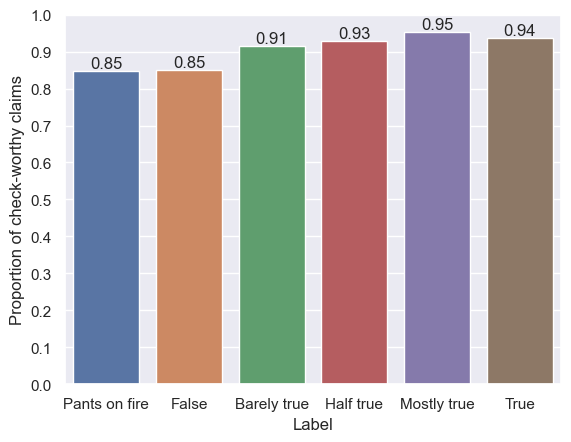

,label,statement,check_worthiness
id,,,
162.json,0,"Rudy Giuliani is ""probably the most underquali...",0.0
11690.json,0,Says Marco Rubio is the one for an open border.,0.0
5043.json,0,What is the proper collective noun for a group...,0.0
3730.json,0,The people of Rhode Island dont want same-sex ...,0.0
11555.json,0,Says that Starbucks took Christmas off of thei...,0.0


,label,statement,check_worthiness
id,,,
10215.json,1,I dont know who (Jonathan Gruber) is.,0.0
3652.json,1,President Barack Obama took exactly none of hi...,0.0
8187.json,1,Says Terry McAuliffe is the person who invente...,0.0
1978.json,1,On whether a U.S. Supreme Court nominee should...,0.0
8755.json,1,The amount of attention paid this week to Chri...,0.0


,label,statement,check_worthiness
id,,,
12981.json,2,"They were going to build the wall a while ago,...",0.0
13370.json,2,Says HB2 hasnt moved the needle one iota on No...,0.0
13026.json,2,Says Hillary Clinton said the Veterans Affairs...,0.0
10879.json,2,The Supreme Court cant overrule the other two ...,0.0
4022.json,2,We do not want to raise anybodys tax rates. Th...,0.0


,label,statement,check_worthiness
id,,,
9028.json,3,The economic turnaround started at the end of ...,0.0
2109.json,3,I think it is unacceptable for the Chinese tod...,0.0
4267.json,3,On how money from a possible lease of the Ohio...,0.0
1347.json,3,On legalizing illegal immigrants.,0.0
12285.json,3,We know that Saudi Arabia started al-Qaida.,0.0


,label,statement,check_worthiness
id,,,
2020.json,4,The insurance commissioner cant do squat about...,0.0
7916.json,4,Immigrants are more fertile.,0.0
10295.json,4,"We are younger than our competitors, and this ...",0.0
8443.json,4,Common Core is not from the federal government...,0.0
9103.json,4,I was the most bipartisan senator in the Unite...,0.0


,label,statement,check_worthiness
id,,,
7550.json,5,We have a federal government that thinks they ...,0.0
10386.json,5,I belong to the AFL-CIO.,0.0
3054.json,5,"Whether you like to admit it or not, half our ...",0.0
772.json,5,You ... said that Barack Obama was not ready t...,0.0
968.json,5,Warren (Buffett) still does support me.,0.0


In [87]:
%autoreload

from liar_utils import LIARLabel
from plotting_utils import show_bar_plot
liar = pd.read_csv("../results/LIAR/checkworthiness.csv", index_col=0)
liar.head()
label_to_name = {
    LIARLabel.PANTS_FIRE: "Pants on fire",
    LIARLabel.FALSE: "False",
    LIARLabel.BARELY_TRUE: "Barely true",
    LIARLabel.HALF_TRUE: "Half true",
    LIARLabel.MOSTLY_TRUE: "Mostly true",
    LIARLabel.TRUE: "True"
}
x = [label_to_name[label] for label in LIARLabel]
y = [liar[liar["label"] == label.value]["check_worthiness"].mean() for label in LIARLabel]
file_path = f"../figures/liar/checkworthiness/checkworthiness.png"

os.makedirs(os.path.dirname(file_path), exist_ok=True)
show_bar_plot(
    x, 
    y, 
    xlabel="Label", 
    ylabel="Proportion of check-worthy claims", 
    y_ticks=[i*0.1 for i in range(11)],
    file_path=file_path, 
    force_save=True,
    use_bar_labels=True,
)

# Look for non-checkworthy claims for each label
folder = "../results/LIAR/non-checkworthy"
os.makedirs(folder, exist_ok=True)
for label in LIARLabel:
    non_checkworthy = liar.query(f"label == {label.value} and check_worthiness == 0")
    non_checkworthy.to_csv(f"{folder}/{label.name}.csv")
    display(non_checkworthy.head())